# General imports

In [1]:
import numpy as np

from geograypher.cameras.derived_cameras import MetashapeCameraSet
from geograypher.cameras.segmentor import SegmentorPhotogrammetryCameraSet
from geograypher.meshes import TexturedPhotogrammetryMesh
from geograypher.segmentation.derived_segmentors import LookUpSegmentor
from geograypher.constants import (
    EXAMPLE_CAMERAS_FILENAME,
    EXAMPLE_MESH_FILENAME,
    EXAMPLE_IMAGE_FOLDER,
    EXAMPLE_LABELS_FILENAME,
    EXAMPLE_PREDICTED_LABELS_FOLDER,
    EXAMPLE_DTM_FILE,
    EXAMPLE_AGGREGATED_FACE_LABELS_FILE,
    EXAMPLE_PREDICTED_VECTOR_LABELS_FILE,
    EXAMPLE_LABEL_NAMES,
    EXAMPLE_IDS_TO_LABELS,
    TEN_CLASS_VIS_KWARGS,
)

# Processing parameters

In [2]:
# Skip re-computing the aggregation and use a saved version
USE_CACHED_AGGREGATION = False
# Processing parameters
HEIGHT_ABOVE_GROUND_THRESH = 2  # Height above the DTM to consider not ground
MESH_DOWNSAMPLE_TARGET = 0.25  # Downsample the mesh to this fraction
AGGREGATE_IMAGE_SCALE = 0.25  # Aggregate images at this scale resolution
BUFFER_RADIUS_METER = 50  # Include cameras within this radius of labeled points
MESH_VIS_KWARGS = TEN_CLASS_VIS_KWARGS

IDS_TO_LABELS = EXAMPLE_IDS_TO_LABELS
CAMERAS_FILENAME = EXAMPLE_CAMERAS_FILENAME
MESH_FILENAME = EXAMPLE_MESH_FILENAME
IMAGE_FOLDER = EXAMPLE_IMAGE_FOLDER
LABELS_FILENAME = EXAMPLE_LABELS_FILENAME
PREDICTED_IMAGE_LABELS_FOLDER = EXAMPLE_PREDICTED_LABELS_FOLDER
DTM_FILE = EXAMPLE_DTM_FILE
AGGREGATED_FACE_LABELS_FILE = EXAMPLE_AGGREGATED_FACE_LABELS_FILE
PREDICTED_VECTOR_LABELS_FILE = EXAMPLE_PREDICTED_VECTOR_LABELS_FILE

# Load the mesh

In [3]:
mesh = TexturedPhotogrammetryMesh(
    MESH_FILENAME,
    transform_filename=EXAMPLE_CAMERAS_FILENAME,
    IDs_to_labels=IDS_TO_LABELS,
)

Loading transform to EPSG:4326
Loading mesh
Reading the mesh


/ofo-share/repos-david/conda/envs/geograypher/lib/python3.9/site-packages/pyvista/plotting/plotter.py:149: UserWarning: 
This system does not appear to be running an xserver.
PyVista will likely segfault when rendering.

Try starting a virtual frame buffer with xvfb, or using
  ``pyvista.start_xvfb()``

  warnings.warn(


Selecting an ROI from mesh
Extracting faces from mesh
Loading texture
No texture provided


# Load the camera set and subsample

In [4]:
# Create camera set
camera_set = MetashapeCameraSet(CAMERAS_FILENAME, IMAGE_FOLDER)
# Extract cameras near the training data
training_camera_set = camera_set.get_subset_ROI(
    ROI=LABELS_FILENAME, buffer_radius_meters=BUFFER_RADIUS_METER
)

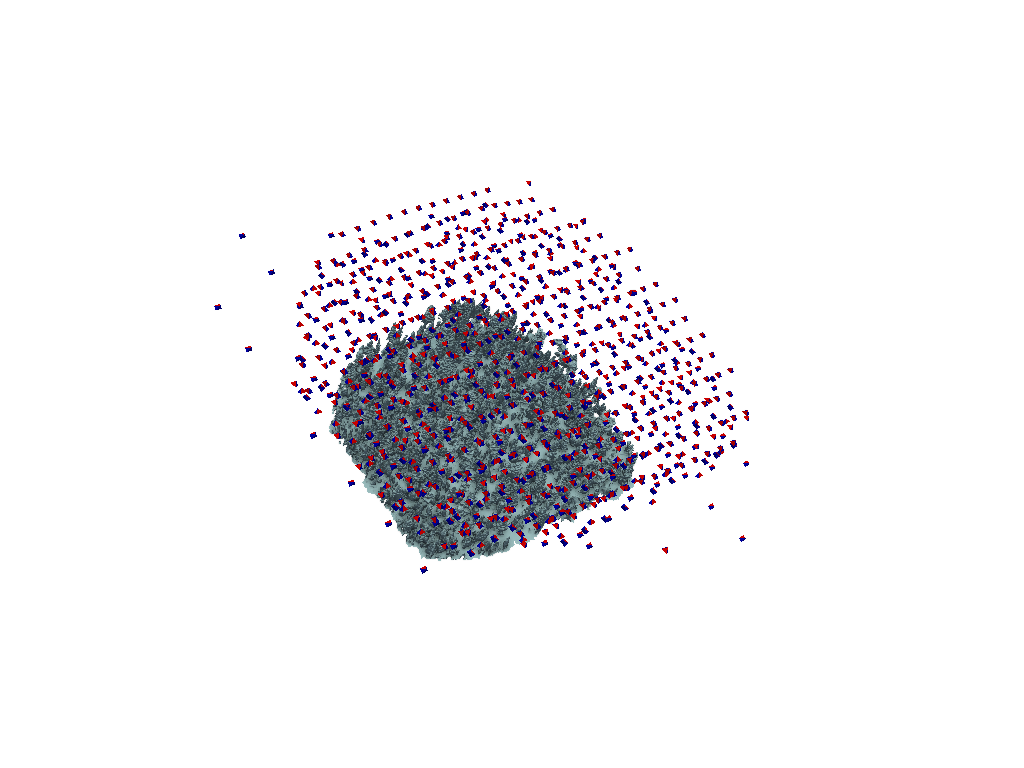

In [5]:
mesh.vis(camera_set=camera_set, force_xvfb=True)

In [6]:
segmentor = LookUpSegmentor(
    base_folder=IMAGE_FOLDER,
    lookup_folder=PREDICTED_IMAGE_LABELS_FOLDER,
    num_classes=len(mesh.get_label_names()),
)

segmentor_camera_set = SegmentorPhotogrammetryCameraSet(
    training_camera_set, segmentor=segmentor
)

This method will be deprecated in favor of get_IDs_to_labels since it doesn't handle non-sequential indices


In [8]:
if USE_CACHED_AGGREGATION:
    aggregated_face_labels = np.load(AGGREGATED_FACE_LABELS_FILE)
else:
    aggregated_face_labels, _ = mesh.aggregate_projected_images(
        segmentor_camera_set,
        aggregate_img_scale=AGGREGATE_IMAGE_SCALE,
    )
    np.save(AGGREGATED_FACE_LABELS_FILE, aggregated_face_labels)

Aggregating projected viewpoints: 100%|██████████| 757/757 [11:40<00:00,  1.08it/s]


In [9]:
predicted_face_classes = np.argmax(
    aggregated_face_labels, axis=1, keepdims=True
).astype(float)
predicted_face_classes = mesh.label_ground_class(
    labels=predicted_face_classes,
    height_above_ground_threshold=HEIGHT_ABOVE_GROUND_THRESH,
    DTM_file=DTM_FILE,
    ground_ID=np.nan,
    set_mesh_texture=False,
)

Sampling values from raster /ofo-share/repos-david/geograypher/data/example_Emerald_Point_data/inputs/dtm.tif: 100%|██████████| 705768/705768 [00:29<00:00, 23527.87it/s]


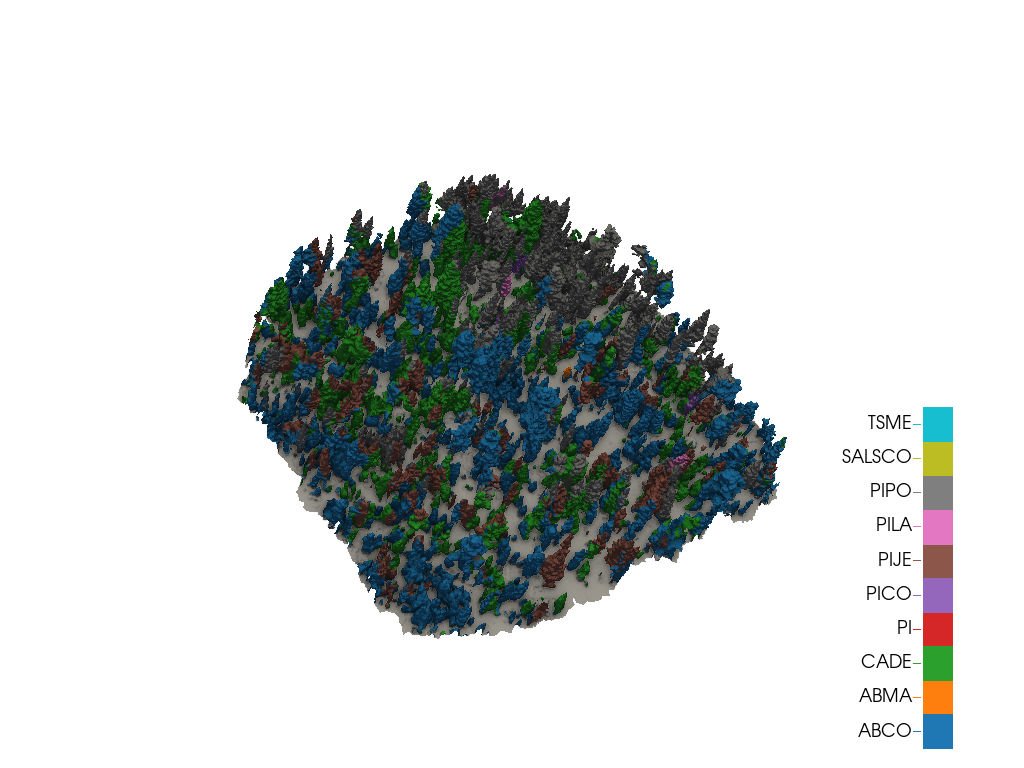

In [10]:
mesh.vis(vis_scalars=predicted_face_classes, mesh_kwargs=MESH_VIS_KWARGS)

# Export the prediction to a vector file

Computing working CRS
Computing faces in working CRS


Converting faces to polygons: 100%|██████████| 1406073/1406073 [00:22<00:00, 62813.64it/s]

Creating dataframe of faces


Creating dataframe of multipolygons


Computing batched unary union with batch size 500000: 100%|██████████| 1/1 [00:35<00:00, 35.09s/it]
Computing batched unary union with batch size 500000: 100%|██████████| 1/1 [00:00<00:00, 38.76it/s]
Computing batched unary union with batch size 500000: 100%|██████████| 1/1 [00:22<00:00, 22.65s/it]
Computing batched unary union with batch size 500000: 100%|██████████| 1/1 [00:00<00:00,  3.90it/s]
Computing batched unary union with batch size 500000: 100%|██████████| 1/1 [00:11<00:00, 11.11s/it]
Computing batched unary union with batch size 500000: 100%|██████████| 1/1 [00:00<00:00,  3.36it/s]
Computing batched unary union with batch size 500000: 100%|██████████| 1/1 [00:21<00:00, 21.42s/it]


Plotting


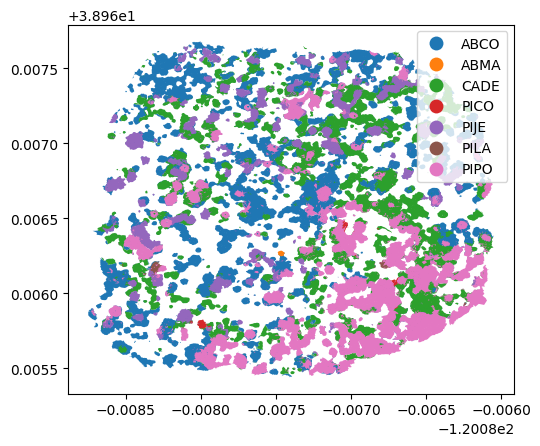

,class_ID,geometry,class_names
0,0.0,"MULTIPOLYGON (((-120.08857 38.96568, -120.0885...",ABCO
1,1.0,"MULTIPOLYGON (((-120.08757 38.96627, -120.0875...",ABMA
2,2.0,"MULTIPOLYGON (((-120.08851 38.96561, -120.0885...",CADE
3,4.0,"MULTIPOLYGON (((-120.08811 38.96574, -120.0881...",PICO
4,5.0,"MULTIPOLYGON (((-120.08864 38.96575, -120.0886...",PIJE
5,6.0,"MULTIPOLYGON (((-120.08832 38.96611, -120.0883...",PILA
6,7.0,"MULTIPOLYGON (((-120.08863 38.96577, -120.0886...",PIPO


In [11]:
mesh.export_face_labels_vector(
    face_labels=np.squeeze(predicted_face_classes),
    export_file=PREDICTED_VECTOR_LABELS_FILE,
    label_names=EXAMPLE_LABEL_NAMES,
    vis=True,
    vis_kwargs={"cmap": "tab10", "vmin": 0, "vmax": 9},
)

# Compare the quality of the prediction with the ground truth (TODO)